In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

### LOAD DATA

In [3]:
transactions = pd.read_csv('transactions.csv')  # columns: customer_id, order_date, order_value
customers = pd.read_csv('customers.csv')        # columns: customer_id, registration_date

### PREPROCESSING

In [4]:
transactions['order_date'] = pd.to_datetime(transactions['order_date'])
customers['registration_date'] = pd.to_datetime(customers['registration_date'])


### Merge transactions with customer registration info

In [5]:
data = pd.merge(transactions, customers, on='customer_id')

### FEATURE ENGINEERING

In [6]:
latest_date = data['order_date'].max()

features = data.groupby('customer_id').agg(
    frequency=('order_date', 'count'),
    recency=('order_date', lambda x: (latest_date - x.max()).days),
    AOV=('order_value', 'mean'),
    total_value=('order_value', 'sum')  # Target variable
).reset_index()

### MODELING

In [7]:
X = features[['frequency', 'recency', 'AOV']]
y = features['total_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model - XGBoost

In [9]:
# Train the model again (in case it was lost due to kernel reset)
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### EVALUATION

In [10]:
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 76.66
RMSE: 104.01


### SEGMENTATION

In [11]:
features['predicted_LTV'] = xgb_model.predict(features[['frequency', 'recency', 'AOV']])

In [12]:
features['LTV_segment'] = pd.qcut(features['predicted_LTV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

### EXPORT RESULTS

In [13]:
features.to_csv('final_ltv_predictions.csv', index=False)
joblib.dump(xgb_model, 'ltv_xgb_model.pkl')

['ltv_xgb_model.pkl']

### VISUALIZATION

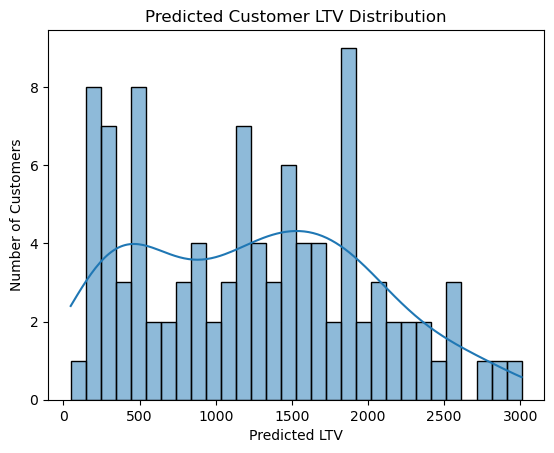

C:\Users\ayush\AppData\Local\Temp\ipykernel_7404\2187879764.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LTV_segment', y='predicted_LTV', data=features, palette='Set3')


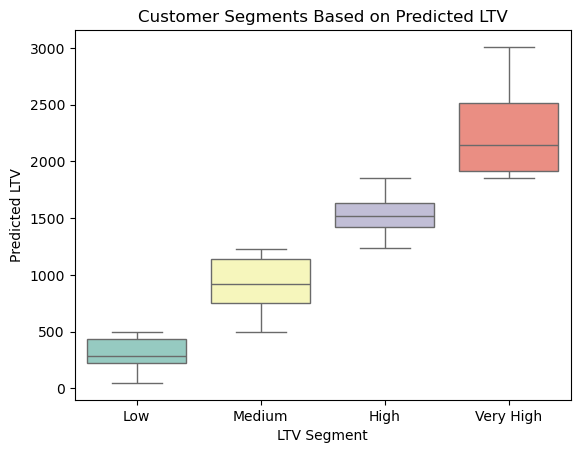

In [14]:
sns.histplot(features['predicted_LTV'], bins=30, kde=True)
plt.title('Predicted Customer LTV Distribution')
plt.xlabel('Predicted LTV')
plt.ylabel('Number of Customers')
plt.show()

sns.boxplot(x='LTV_segment', y='predicted_LTV', data=features, palette='Set3')
plt.title('Customer Segments Based on Predicted LTV')
plt.xlabel('LTV Segment')
plt.ylabel('Predicted LTV')
plt.show()
